In [30]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns

#1: Самостоятельно реализовать функцию gradient_descent(X, y), которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал методом градиентного спуска (Batch Gradient Descent, GD) и возвращая вектор весов w. В качестве функционала можно выбрать, например, функцию ошибок MSE + L2-регуляризатор. Использовать матрично-векторные операции для вычисления градиента.

Отнаследовался от базового класса sklearn, чтобы иметь возможность работать с пайплайнами

In [31]:
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from enum import Enum


class BatchGradientDescent(BaseEstimator):

    def gradient_descent(X, y, theta, learning_rate, n_iter, alpha):
        '''
        X    = Matrix of X with added bias units
        y    = Vector of Y
        theta= Vector of weights
        learning_rate = descent step
        iterations = no of iterations
        alpha = component for L2 reg

        returns theta
        '''
        m = len(y)
        for _ in range(n_iter):
            prediction = np.dot(X,theta)
            # https://towardsdatascience.com/regularization-in-deep-learning-l1-l2-and-dropout-377e75acc036
            theta = (1 - learning_rate*alpha) * theta -(1/m)*learning_rate*(X.T.dot((prediction - y)))
            
        return theta.flatten()


    def __init__(self, learning_rate=0.001, n_iter=1000, alpha=1.0) -> None:
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.alpha = alpha

    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit

        self.X_ = X
        self.y_ = y

        features_num = X.shape[1]
        theta = np.array(np.zeros((features_num + 1, 1)))
        X_b = np.c_[np.ones(len(X)), X]
        y = np.c_[y]

        self.coef_ = BatchGradientDescent.gradient_descent(
            X_b, y, theta,
            learning_rate=self.learning_rate,
            n_iter=self.n_iter,
            alpha=self.alpha
        )
        self.n_features_in_ = features_num

        return self

    def predict(self, X):

        # Check if fit has been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)
        X_b = np.c_[np.ones(len(X)), X]

        return self.coef_.dot(X_b.T)


... и проверил его

In [32]:
from sklearn.utils.estimator_checks import check_estimator
a = BatchGradientDescent()
check_estimator(a)

/var/folders/bk/7gs4zw15053b3hmzsf_slygc0000gn/T/ipykernel_9713/2527986290.py:23: RuntimeWarning: invalid value encountered in subtract
  theta = (1 - learning_rate*alpha) * theta -(1/m)*learning_rate*(X.T.dot((prediction - y)))
/var/folders/bk/7gs4zw15053b3hmzsf_slygc0000gn/T/ipykernel_9713/2527986290.py:23: RuntimeWarning: invalid value encountered in subtract
  theta = (1 - learning_rate*alpha) * theta -(1/m)*learning_rate*(X.T.dot((prediction - y)))
/var/folders/bk/7gs4zw15053b3hmzsf_slygc0000gn/T/ipykernel_9713/2527986290.py:23: RuntimeWarning: invalid value encountered in subtract
  theta = (1 - learning_rate*alpha) * theta -(1/m)*learning_rate*(X.T.dot((prediction - y)))
/var/folders/bk/7gs4zw15053b3hmzsf_slygc0000gn/T/ipykernel_9713/2527986290.py:23: RuntimeWarning: invalid value encountered in subtract
  theta = (1 - learning_rate*alpha) * theta -(1/m)*learning_rate*(X.T.dot((prediction - y)))


#2: Найти данные, на которых интересно будет решать задачу регрессии. Зависимость целевого признака от нецелевых должна быть не слишком сложной, чтобы обученная линейная модель смогла показать приемлимый результат.

Датасет: https://www.kaggle.com/datasets/whenamancodes/students-performance-in-exams

#3: Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).

In [33]:
df = pd.read_csv("./exams.csv")

# data cleaning не нужен:
print(df.isnull().values.any())
df.head()


False


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


#4: Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.

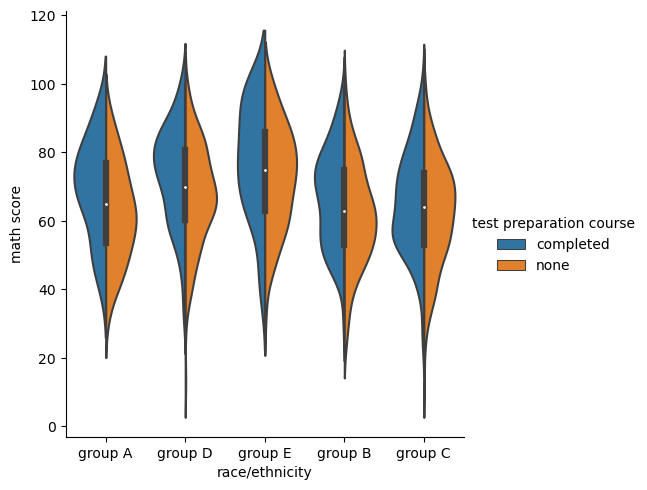

In [77]:
sns.catplot(
    data=df, x="race/ethnicity", y="math score", hue="test preparation course",
    kind="violin", split=True,
)


можем наблюдать, что зависимость между подготовкой и результатом есть, но слабая. При этом в рассовой/этнической группе А, D подготовка к экзамену дает хорошие результаты, в группе E, B она дает средние, в группе C - почему-то отрицательные.

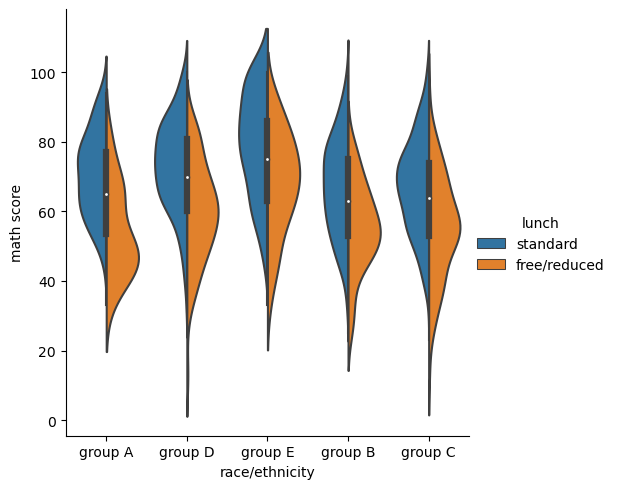

In [81]:

sns.catplot(
    data=df, x="race/ethnicity", y="math score", hue="lunch",
    kind="violin", split=True,
)


на этой диаграмме видно, что есть сильная положительная корреляция между тем, как студенты едят, и как они пишут экзамен

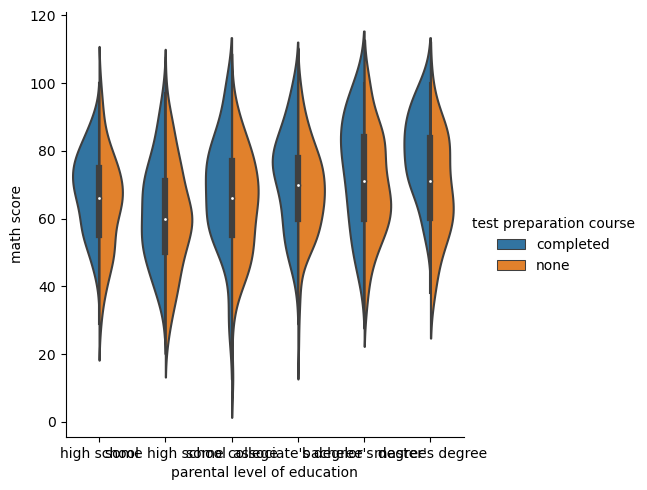

In [80]:

sns.catplot(
    data=df, x="parental level of education", y="math score", hue="test preparation course",
    kind="violin", split=True,
)

можно заметить, что при низком и высоком уровне образования родителей после завершения подготовительного курса студенты с большей вероятностью напишут тест хорошо

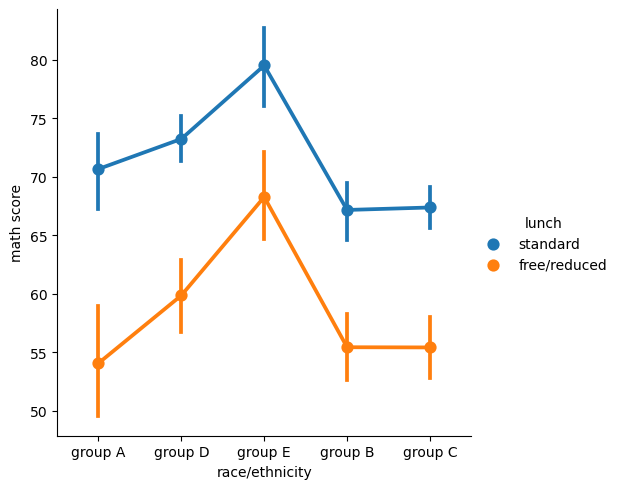

In [79]:
sns.catplot(data=df, x="race/ethnicity", y="math score", hue="lunch", kind="point")

студенты из рассово-этнической группы E в общем случае показывают результаты лучше остальных

#5: При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).

In [36]:
# сделаем еще одну колонку: сытый и подготовленный:

df["full_and_prepared"] = 0
df.loc[(df['lunch'] == "standard") & (df['test preparation course'] == "completed"), 'full_and_prepared'] = 1

In [37]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,full_and_prepared
0,male,group A,high school,standard,completed,67,67,63,1
1,female,group D,some high school,free/reduced,none,40,59,55,0
2,male,group E,some college,free/reduced,none,59,60,50,0
3,male,group B,high school,standard,none,77,78,68,0
4,male,group E,associate's degree,standard,completed,78,73,68,1


In [38]:
categorical_columns = ["gender", "race/ethnicity", "parental level of education", "lunch", "test preparation course", "full_and_prepared"]
df.drop(["reading score", "writing score"], axis=1, inplace=True)
df.head()

X = df.drop("math score", axis=1)
y = df["math score"]

le_X = X.copy()
for categorical_column in categorical_columns:
    le_X[categorical_column] = le_X[categorical_column].astype('category')
    le_X[categorical_column] = le_X[categorical_column].cat.codes

le_X.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,full_and_prepared
0,1,0,2,1,0,1
1,0,3,5,0,1,0
2,1,4,4,0,1,0
3,1,1,2,1,1,0
4,1,4,0,1,0,1


<AxesSubplot:>

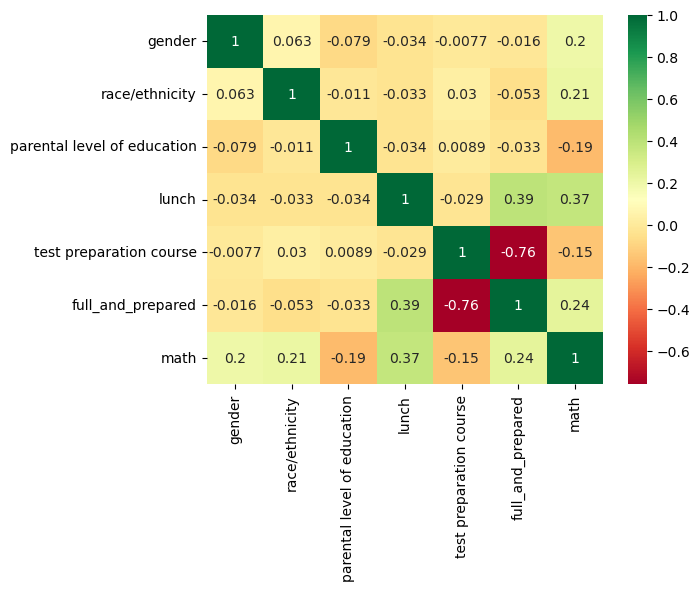

In [39]:
show_df = le_X.copy()
show_df["math"] = y

sns.heatmap(show_df.corr(), annot=True, cmap='RdYlGn')

видно, что новый признак имеет хорошую корреляцию с целевым

#6: Случайным образом разбить данные на обучающую и тестовую выборки, используя методы существующих библиотек.


In [40]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    le_X, y, test_size=.2, random_state=42
)


Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя Recursive Feature Elimination (RFE).

In [41]:
ohe_df = pd.get_dummies(X, columns=categorical_columns)

rfecv = sk.feature_selection.RFECV(estimator=sk.linear_model.Ridge(), step=1, cv=5, scoring='r2')
rfecv.fit(X_train, y_train)

selected_features = list(X_train.columns[rfecv.support_])

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % selected_features)

Optimal number of features: 6
Selected features: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'full_and_prepared']


#12: Использовал RFECV для автоматического определения нужного количества фич, оказалось, что нужны все

#7: При обучении моделей использовать масштабирование данных.

In [42]:
from sklearn.pipeline import Pipeline

batch_gradient_pipeline = Pipeline([
    ('scaling', sk.preprocessing.StandardScaler()),
    ('bgd', BatchGradientDescent(alpha= 0.0001, learning_rate=0.1, n_iter=10000))
])

 #8: Обучить модель на обучающей выборке, используя функцию gradient_descent(X, y). Оценить качество модели на обучающей и тестовой выборках, используя MSE, RMSE и R2.

In [43]:
from sklearn.metrics import mean_squared_error, r2_score

batch_gradient_model = batch_gradient_pipeline.fit(X_train, y_train)
y_pred = batch_gradient_model.predict(X_test)

print("Test MSE =", mean_squared_error(y_test, y_pred, squared=True)) # MSE
print("Test RMSE =", mean_squared_error(y_test,  y_pred, squared=False)) # RMSE
print("Test R2 =", r2_score(y_test, y_pred)) # R2



Test MSE = 167.1727381294329
Test RMSE = 12.929529694827762
Test R2 = 0.28576293554259014


 #9: Обучить модель, используя существующую библиотеку. Например, в sklearn для L2-регуляризатора можно использовать Ridge. Сравнить качество с вашей реализацией.

In [44]:
from sklearn.pipeline import Pipeline

ridge_pipeline = Pipeline([
    ('scaling', sk.preprocessing.StandardScaler()),
    ('ridge', sk.linear_model.Ridge(alpha=5.))
])

ridge_model = ridge_pipeline.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)

print("Test MSE =", mean_squared_error(y_test, y_pred, squared=True)) # MSE
print("Test RMSE =", mean_squared_error(y_test, y_pred, squared=False)) # RMSE
print("Test R2 =", r2_score(y_test, y_pred)) # R2

Test MSE = 167.10837109769352
Test RMSE = 12.9270403069571
Test R2 = 0.28603794042862474


 #10: Повторить тоже самое, но используя кросс-валидацию.

In [45]:
from sklearn.model_selection import cross_val_score

def get_scores(model, X_train, y_train):

    cv_scores_mse = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    cv_scores_rmse = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
    cv_scores_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring="r2")

    print("Mean CV MSE = %.4f" % np.mean(-cv_scores_mse))
    print("Mean CV RMSE = %.4f" % np.mean(-cv_scores_rmse))
    print("Mean CV R2 = %.4f" % np.mean(cv_scores_r2))

print("Scores for BatchGradientDescent:")
get_scores(batch_gradient_model, X_train, y_train)
print("Scores for Ridge:")
get_scores(ridge_model, X_train, y_train)

Scores for BatchGradientDescent:
Mean CV MSE = 176.1139
Mean CV RMSE = 13.2606
Mean CV R2 = 0.2561
Scores for Ridge:
Mean CV MSE = 176.0793
Mean CV RMSE = 13.2593
Mean CV R2 = 0.2563


Вывод: Надо настраивать гиперпараметры

#11: Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, STD), где k --- количество фолдов в кросс-валидации, E --- мат. ожидание и STD --- стандартное отклонение. Сделать выводы.

In [159]:
columns = ["Fold1", "Fold2", "Fold3", "Fold4", "Fold5", "E", "STD"]

scorings = [("neg_mean_squared_error", "mse"), ("neg_root_mean_squared_error", "rmse"), ("r2", "r2")]

metrics_sum = pd.DataFrame()

for scoring, scoring_short in scorings:
    k_folds = sk.model_selection.KFold(n_splits = 5, random_state=42, shuffle=True)
    metrics = sk.model_selection.cross_validate(batch_gradient_model, le_X, y, cv=k_folds, scoring=scoring, return_train_score=True)

    metrics_summary = pd.DataFrame(
        metrics, index=["Fold1", "Fold2", "Fold3", "Fold4", "Fold5"]
    )[["test_score", "train_score"]].rename(columns={"test_score": f"{scoring_short}-test", "train_score": f"{scoring_short}-train"})

    metrics_summary = np.abs(metrics_summary)

    if metrics_sum.empty:
        metrics_sum = metrics_summary
    else:
        metrics_sum = pd.concat([metrics_sum, metrics_summary], axis=1)

metrics_sum = metrics_sum.T

metrics_sum["E"] = metrics_sum.mean(axis=1)
metrics_sum["STD"] = metrics_sum.std(axis=1)
metrics_sum

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-test,167.172738,166.082417,178.855894,178.850876,183.194585,174.831302,6.891958
mse-train,172.878605,173.566978,170.079521,169.831027,168.797137,171.030654,1.853657
rmse-test,12.929530,12.887297,13.373702,13.373514,13.534939,13.219796,0.261320
rmse-train,13.148331,13.174482,13.041454,13.031923,12.992195,13.077677,0.070818
r2-test,0.285763,0.198428,0.272541,0.255931,0.275349,0.257602,0.031098
r2-train,0.272400,0.288571,0.275456,0.280896,0.273294,0.278123,0.006001


Выводы:
1) на тестовой выборке точность всегда меньше, так как мы обучемся на ней
2) на разных фолдах получаются разные по точности результаты из-за неоднородности данных

#13: Во все ваши реализации добавить возможность настройки нужных гиперпараметров, а в процессе обучения всех моделей осуществить подбор оптимальных значений этих гиперпараметров.


In [ ]:
alpha_grid = [.0001, .001, .01, .1, 1., 2.]
n_iter_grid = [100, 1000, 10000]
eta_grid = alpha_grid = [1., .1, .001, .0001]

searcher = sk.model_selection.GridSearchCV(
    estimator=BatchGradientDescent(),
    param_grid=[{"alpha": alpha_grid, "n_iter": n_iter_grid, "learning_rate": eta_grid}],
    scoring="r2",
    cv=5
)
searcher.fit(X_train, y_train)

print(searcher.best_params_) # {'alpha': 0.0001, 'learning_rate': 0.1, 'n_iter': 10000}

In [48]:
alpha_grid = [.01, .1, 1., 2., 3., 5., 6., 7.]

searcher = sk.model_selection.GridSearchCV(
    estimator=sk.linear_model.Ridge(),
    param_grid=[{"alpha": alpha_grid}],
    scoring="neg_root_mean_squared_error",
    cv=5
)
searcher.fit(X_train, y_train)

print(searcher.best_params_)

{'alpha': 3.0}


In [49]:
class StocasticGradientDescent(BaseEstimator):

    def gradient_descent(X, y, theta, learning_rate, n_iter, alpha):
        '''
        X    = Matrix of X with added bias units
        y    = Vector of Y
        theta= Vector of weights
        learning_rate = descent step
        iterations = no of iterations
        alpha = component for L2 reg

        returns theta
        '''
        m = len(y)
        for _ in range(n_iter):
            rand_ind = np.random.randint(0,m) # choose random elem
            X_i = X[rand_ind,:].reshape(1,X.shape[1]) # choose elem from X at index ```random_ind```
            y_i = y[rand_ind].reshape(1,1) # prepare y for matrix operations
            prediction = np.dot(X_i,theta)
        
            # https://towardsdatascience.com/regularization-in-deep-learning-l1-l2-and-dropout-377e75acc036
            theta = (1 - learning_rate*alpha) * theta -(1/m)*learning_rate*(X.T.dot((prediction - y)))
            
        return theta.flatten()

    def __init__(self, learning_rate=0.001, n_iter=1000, alpha=1.0) -> None:
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.alpha = alpha

    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit

        self.X_ = X
        self.y_ = y

        features_num = X.shape[1]
        theta = np.array(np.zeros((features_num + 1, 1)))
        X_b = np.c_[np.ones(len(X)), X]
        y = np.c_[y]

        self.coef_ = StocasticGradientDescent.gradient_descent(
            X_b, y, theta,
            learning_rate=self.learning_rate,
            n_iter=self.n_iter,
            alpha=self.alpha
        )
        self.n_features_in_ = features_num

        return self

    def predict(self, X):

        # Check if fit has been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)
        X_b = np.c_[np.ones(len(X)), X]

        return self.coef_.dot(X_b.T)

from sklearn.utils.estimator_checks import check_estimator
a = BatchGradientDescent()
check_estimator(a)

/var/folders/bk/7gs4zw15053b3hmzsf_slygc0000gn/T/ipykernel_9713/2527986290.py:23: RuntimeWarning: invalid value encountered in subtract
  theta = (1 - learning_rate*alpha) * theta -(1/m)*learning_rate*(X.T.dot((prediction - y)))
/var/folders/bk/7gs4zw15053b3hmzsf_slygc0000gn/T/ipykernel_9713/2527986290.py:23: RuntimeWarning: invalid value encountered in subtract
  theta = (1 - learning_rate*alpha) * theta -(1/m)*learning_rate*(X.T.dot((prediction - y)))
/var/folders/bk/7gs4zw15053b3hmzsf_slygc0000gn/T/ipykernel_9713/2527986290.py:23: RuntimeWarning: invalid value encountered in subtract
  theta = (1 - learning_rate*alpha) * theta -(1/m)*learning_rate*(X.T.dot((prediction - y)))
/var/folders/bk/7gs4zw15053b3hmzsf_slygc0000gn/T/ipykernel_9713/2527986290.py:23: RuntimeWarning: invalid value encountered in subtract
  theta = (1 - learning_rate*alpha) * theta -(1/m)*learning_rate*(X.T.dot((prediction - y)))


In [ ]:
alpha_grid = [.01, .1, 1., 2., 3., 5., 6., 7.]
n_iter_grid = [100, 1000, 10000]
eta_grid = [1., .1, .001, .0001]

searcher = sk.model_selection.GridSearchCV(
    estimator=StocasticGradientDescent(),
    param_grid=[{"alpha": alpha_grid, "n_iter": n_iter_grid, "learning_rate": eta_grid}],
    scoring="neg_root_mean_squared_error",
    cv=5
)
searcher.fit(X_train, y_train)

print(searcher.best_params_) # {'alpha': 1.0, 'learning_rate': 0.001, 'n_iter': 10000}

In [61]:
sgd_pipeline = Pipeline([
    ('scaling', sk.preprocessing.StandardScaler()),
    ('sgd', StocasticGradientDescent(alpha=1.0, learning_rate=0.001, n_iter=100000))
])

sgd_model = sgd_pipeline.fit(X_train, y_train)
y_pred = sgd_model.predict(X_test)

print("Test MSE =", mean_squared_error(y_test, y_pred, squared=True)) # MSE
print("Test RMSE =", mean_squared_error(y_test, y_pred, squared=False)) # RMSE
print("Test R2 =", r2_score(y_test, y_pred)) # R2

Test MSE = 1265.5703389729977
Test RMSE = 35.57485543151226
Test R2 = -4.407085233434342


достаточно странно, что получаются плохие результаты. может, данные не помогают, их слишком мало или в них много шума и мало корреляции?
эту гипотезу позже подтвердит пакетный гс: при использовании GridSearch лучший batch_size - 1000 (все возможные элементы)

In [60]:
class MinibatchGradientDescent(BaseEstimator):

    def gradient_descent(X, y, theta, learning_rate, n_iter, alpha, batch_size):
        '''
        X    = Matrix of X with added bias units
        y    = Vector of Y
        theta= Vector of weights
        learning_rate = descent step
        iterations = no of iterations
        alpha= component for L2 reg
        batch_size = size of used batches

        returns theta
        '''
        m = len(y)
        
        for _ in range(n_iter):
            indices = np.random.permutation(m) # мешаем индексы
            X = X[indices]
            y = y[indices]

            for i in range(0,m,batch_size): # проходим по перемешанным индексам по очереди
                X_i = X[i:i+batch_size]
                y_i = y[i:i+batch_size]
            
                prediction = np.dot(X_i,theta) # делаем оценку только на части элементов

                theta = (1 - learning_rate*alpha) * theta -(1/m)*learning_rate*(X_i.T.dot((prediction - y_i)))

        return theta.flatten()

    def __init__(self, learning_rate=0.001, n_iter=1000, alpha=1.0, batch_size=20) -> None:
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.alpha = alpha
        self.batch_size=batch_size


    def fit(self, X, y):

        # Check that X and y have correct shape

        X, y = check_X_y(X, y)
        # Store the classes seen during fit

        self.X_ = X
        self.y_ = y

        features_num = X.shape[1]
        theta = np.array(np.zeros((features_num + 1, 1)))
        X_b = np.c_[np.ones(len(X)), X]
        y = np.c_[y]

        self.coef_ = MinibatchGradientDescent.gradient_descent(
            X_b, y, theta,
            learning_rate=self.learning_rate,
            n_iter=self.n_iter,
            alpha=self.alpha,
            batch_size=self.batch_size
        )
        self.n_features_in_ = features_num

        return self

    def predict(self, X):

        # Check if fit has been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)
        X_b = np.c_[np.ones(len(X)), X]

        return self.coef_.dot(X_b.T)

from sklearn.utils.estimator_checks import check_estimator
a = MinibatchGradientDescent()
check_estimator(a)

/var/folders/bk/7gs4zw15053b3hmzsf_slygc0000gn/T/ipykernel_9713/1866181423.py:28: RuntimeWarning: invalid value encountered in subtract
  theta = (1 - learning_rate*alpha) * theta -(1/m)*learning_rate*(X_i.T.dot((prediction - y_i)))
/var/folders/bk/7gs4zw15053b3hmzsf_slygc0000gn/T/ipykernel_9713/1866181423.py:28: RuntimeWarning: invalid value encountered in subtract
  theta = (1 - learning_rate*alpha) * theta -(1/m)*learning_rate*(X_i.T.dot((prediction - y_i)))
/var/folders/bk/7gs4zw15053b3hmzsf_slygc0000gn/T/ipykernel_9713/1866181423.py:28: RuntimeWarning: invalid value encountered in subtract
  theta = (1 - learning_rate*alpha) * theta -(1/m)*learning_rate*(X_i.T.dot((prediction - y_i)))
/var/folders/bk/7gs4zw15053b3hmzsf_slygc0000gn/T/ipykernel_9713/1866181423.py:28: RuntimeWarning: invalid value encountered in subtract
  theta = (1 - learning_rate*alpha) * theta -(1/m)*learning_rate*(X_i.T.dot((prediction - y_i)))


In [ ]:
alpha_grid = [.01, .1, 1., 2.,]
n_iter_grid = [1000] # иначе долго
eta_grid = [1., .1, .001]
batch_size_grid = [250, 400, 600, 1000]

searcher = sk.model_selection.GridSearchCV(
    estimator=MinibatchGradientDescent(),
    param_grid=[{"alpha": alpha_grid, "n_iter": n_iter_grid, "learning_rate": eta_grid, "batch_size": batch_size_grid}],
    scoring="neg_root_mean_squared_error",
    cv=5
)
searcher.fit(X_train, y_train)

print(searcher.best_params_) # {'alpha': 0.01, 'batch_size': 1000, 'learning_rate': 0.1, 'n_iter': 1000}

In [76]:
mgd_pipeline = Pipeline([
    ('scaling', sk.preprocessing.StandardScaler()),
    ('sgd', MinibatchGradientDescent(alpha=0.01, learning_rate=0.1, n_iter=1000, batch_size=1000))
])

mgd_model = mgd_pipeline.fit(X_train, y_train)
y_pred = mgd_model.predict(X_test)

print("Test MSE =", mean_squared_error(y_test, y_pred, squared=True)) # MSE
print("Test RMSE =", mean_squared_error(y_test, y_pred, squared=False)) # RMSE
print("Test R2 =", r2_score(y_test, y_pred)) # R2

Test MSE = 168.15958412636365
Test RMSE = 12.967636026908052
Test R2 = 0.281546685956646
